In [1]:
import pandas as pd
from py2neo import Graph

import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import datetime

import pyspark as spark

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import *
from pyspark.sql import functions as F

from sklearn.utils import resample

In [2]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "SFi5gS09lHiMfu9VuJTg"))

In [3]:
date_query = "match (Offense)-[m:MULTIPLE_COMPLAINTS]-(Location) \
return apoc.temporal.format(date(m.first_complaint),'yyyy-MM') as date, count(*) as count"

In [4]:
by_date = graph.run(date_query).to_data_frame()

In [125]:
by_date = by_date.sort_values('date')

In [6]:
by_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    27 non-null     object
 1   count   27 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 648.0+ bytes


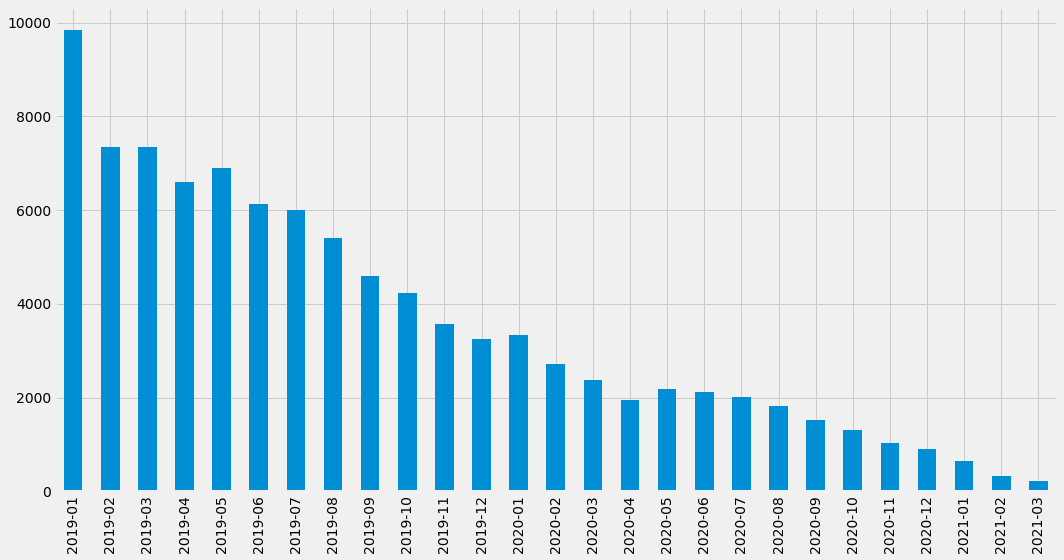

In [7]:
plt.style.use('fivethirtyeight')
ax = by_date.plot(kind='bar', x='date', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [8]:
early_complaints = 'MATCH (o:Offense)-[m:MULTIPLE_COMPLAINTS]->(l:Location) \
WHERE apoc.convert.toString(m.first_complaint) < "2019-12-01" \
MERGE (o)-[me:EARLY_COMPLAINTS {first_complaint: m.first_complaint}]->(l) \
SET me.previous_complaints = m.previous_complaints'

In [11]:
later_complaints = 'MATCH (o:Offense)-[m:MULTIPLE_COMPLAINTS]->(l:Location) \
WHERE apoc.convert.toString(m.first_complaint) >= "2019-12-01" \
MERGE (o)-[me:LATER_COMPLAINTS {first_complaint: m.first_complaint}]->(l) \
SET me.previous_complaints = m.previous_complaints'

In [12]:
mult_complaints_query = "match (o:Offense)<-[ :COMMITTED_OFFENSE]-(c:Complaint)-[:LOCATED_AT]->(l:Location) \
with c, l, o \
order by l.location_id, c.complaint_date \
with l,o, collect(date(c.complaint_date))[0] as date, count(*) as prev_complaints \
MERGE (o)-[pc:MULTIPLE_COMPLAINTS {first_complaint: date}]->(l) \
set pc.previous_complaints = prev_complaints"

In [13]:
delete_single_complaints = "MATCH ()-[r:MULTIPLE_COMPLAINTS]->() where r.previous_complaints <= 1 delete r"

# Training Data

In [14]:
train_existing_links_query = "MATCH (offense)-[:EARLY_COMPLAINTS]->(loc) RETURN id(offense) AS node1, id(loc) AS node2, 1 AS label"

In [15]:
train_existing = graph.run(train_existing_links_query).to_data_frame()
train_existing

,node1,node2,label
0,270298,653007,1
1,270298,660983,1
2,270298,664265,1
3,270298,655983,1
4,270298,650496,1
...,...,...,...
33973,270322,655709,1
33974,270322,645687,1
33975,270322,640106,1
33976,270324,641422,1


In [16]:
train_missing_links_query = "MATCH (o:Offense) WHERE (o)-[:EARLY_COMPLAINTS]-() MATCH (o)-[:EARLY_COMPLAINTS*2]-(l) WHERE not((o)-[:EARLY_COMPLAINTS]-(l)) RETURN id(o) AS node1, id(l) AS node2, 0 AS label"

In [17]:
train_missing = graph.run(train_missing_links_query).to_data_frame()

In [18]:
train_missing

,node1,node2,label
0,270298,270305,0
1,270298,270303,0
2,270298,270305,0
3,270298,270309,0
4,270298,270301,0
...,...,...,...
48311,270324,270303,0
48312,270324,270305,0
48313,270324,270311,0
48314,270325,270304,0


In [19]:
train_missing = resample(train_missing, n_samples=33978)
train_missing

,node1,node2,label
23437,270304,270303,0
38880,270309,270300,0
40344,270309,270300,0
40007,270309,270300,0
14001,270303,270305,0
...,...,...,...
28195,270305,270309,0
16676,270303,270300,0
24366,270304,270307,0
17916,270303,270305,0


In [20]:
training_df = train_missing.append(train_existing, ignore_index=True)

In [21]:
training_df['label'] = training_df.label.astype('category')

In [22]:
training_df.groupby('label').count()['node1']

label
0    33978
1    33978
Name: node1, dtype: int64

# Test Data

In [23]:
test_existing_links_query = "MATCH (offense)-[:LATER_COMPLAINTS]->(loc) \
RETURN id(offense) AS node1, id(loc) AS node2, 1 AS label"

In [24]:
test_existing = graph.run(test_existing_links_query).to_data_frame()
test_existing

,node1,node2,label
0,270298,640355,1
1,270298,692107,1
2,270298,641273,1
3,270298,684124,1
4,270298,660442,1
...,...,...,...
13831,270318,643066,1
13832,270320,642610,1
13833,270320,644569,1
13834,270320,641273,1


In [25]:
test_missing_links_query = "MATCH (o:Offense) WHERE (o)-[:LATER_COMPLAINTS]-() \
MATCH (o)-[:LATER_COMPLAINTS*2]-(l) WHERE not((o)-[:LATER_COMPLAINTS]-(l)) \
RETURN id(o) AS node1, id(l) AS node2, 0 AS label"

In [26]:
test_missing = graph.run(test_missing_links_query).to_data_frame()
test_missing

,node1,node2,label
0,270298,270303,0
1,270298,270307,0
2,270298,270320,0
3,270298,270300,0
4,270298,270303,0
...,...,...,...
6165,270320,270305,0
6166,270320,270303,0
6167,270320,270312,0
6168,270320,270312,0


In [27]:
test_missing = resample(test_missing, n_samples=13836)

In [28]:
test_df = test_missing.append(test_existing, ignore_index=True)

In [29]:
test_df['label'] = test_df.label.astype('category')

In [30]:
test_df

,node1,node2,label
0,270300,270309,0
1,270306,270304,0
2,270312,270301,0
3,270304,270309,0
4,270301,270307,0
...,...,...,...
27667,270318,643066,1
27668,270320,642610,1
27669,270320,644569,1
27670,270320,641273,1


In [31]:
test_df.groupby('label').count()['node1']

label
0    13836
1    13836
Name: node1, dtype: int64

In [171]:
def apply_graphy_training_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
    relationshipQuery: "EARLY_COMPLAINTS"}) AS prefAttachment
    """
    pairs = [{"node1": int(row[0]),"node2": int(row[1])} for index, row in data.iterrows()]
    features = graph.run(query, {"pairs": pairs}).to_data_frame()
    return features.merge(data, on=['node1','node2'], how='right')

In [169]:
def apply_graphy_test_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
    relationshipQuery: "LATER_COMPLAINTS"}) AS prefAttachment
    """
    pairs = [{"node1": int(row[0]),"node2": int(row[1])} for index, row in data.iterrows()]
    features = graph.run(query, {"pairs": pairs}).to_data_frame()
    return features.merge(data, on=['node1','node2'], how='right')

In [170]:
training_data = apply_graphy_training_features(training_df)
training_data.drop_duplicates(inplace=True)

IndexError: index out of range

In [ ]:
training_data.groupby('label').count()['node1']

In [ ]:
test_data = apply_graphy_test_features(test_df)
test_data = test_data.drop_duplicates()

In [ ]:
test_data.groupby('label').count()['node1']

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

In [161]:
train_existing = training_data.loc[training_data['label'] == 1]
train_existing

,node1,node2,prefAttachment,sameCommunity,label
23847596,270298,653007,57.0,0.0,1
23847597,270298,660983,57.0,0.0,1
23847598,270298,664265,19.0,0.0,1
23847599,270298,655983,76.0,0.0,1
23847600,270298,650496,76.0,0.0,1
...,...,...,...,...,...
23881569,270322,655709,14.0,0.0,1
23881570,270322,645687,42.0,0.0,1
23881571,270322,640106,56.0,0.0,1
23881572,270324,641422,4.0,0.0,1


In [134]:
train_missing = training_data.loc[training_data['label'] == 0]
train_missing = resample(train_missing,n_samples=33978)
train_missing

,node1,node2,prefAttachment,label
18689558,270308,270299,9.252880e+06,0
461859,270312,270299,2.384229e+08,0
180529,270310,270300,5.981905e+07,0
16124,270300,270303,-5.073985e+08,0
4112,270303,270306,1.308301e+09,0
...,...,...,...,...
1100588,270315,270302,4.652530e+06,0
8272719,270313,270304,7.251343e+06,0
1656066,270299,270308,9.252880e+06,0
1932348,270312,270308,3.395899e+07,0


In [135]:
training_data = train_missing.append(train_existing, ignore_index=True)

In [136]:
training_data.prefAttachment.isna().sum()

0

In [137]:
training_data.groupby('label').count()['node1']

label
0    33978
1    33978
Name: node1, dtype: int64

In [138]:
test_existing = test_data.loc[test_data['label'] == 1]
test_existing

,node1,node2,prefAttachment,label
3372328,270298,640355,118881.0,1
3372329,270298,692107,32634.0,1
3372330,270298,641273,232323.0,1
3372331,270298,684124,7770.0,1
3372332,270298,660442,94794.0,1
...,...,...,...,...
3386159,270318,643066,5016.0,1
3386160,270320,642610,8512.0,1
3386161,270320,644569,11144.0,1
3386162,270320,641273,16744.0,1


In [139]:
test_missing = test_data.loc[test_data['label'] == 0]
test_missing = resample(test_missing,n_samples=13836)
test_missing

,node1,node2,prefAttachment,label
10708,270307,270301,8.054219e+08,0
200745,270299,270306,9.889620e+07,0
13335,270307,270300,7.254658e+08,0
20458,270305,270299,4.370857e+08,0
697008,270311,270304,7.758052e+07,0
...,...,...,...,...
351335,270313,270304,7.251343e+06,0
0,270300,270309,1.169668e+09,0
624286,270298,270300,2.760059e+07,0
725209,270310,270309,5.545075e+07,0


In [140]:
test_data = test_missing.append(test_existing, ignore_index=True)

In [141]:
test_data.prefAttachment.isna().sum()

0

In [142]:
test_data.groupby('label').count()['node1']

label
0    13836
1    13836
Name: node1, dtype: int64

In [143]:
clf=RandomForestClassifier(n_estimators=30)

In [144]:
X_train = training_data[['node1','node2','prefAttachment']]
X_train

,node1,node2,prefAttachment
0,270308,270299,9.252880e+06
1,270312,270299,2.384229e+08
2,270310,270300,5.981905e+07
3,270300,270303,-5.073985e+08
4,270303,270306,1.308301e+09
...,...,...,...
67951,270322,655709,7.533000e+03
67952,270322,645687,1.433700e+04
67953,270322,640106,1.109700e+04
67954,270324,641422,2.943000e+03


In [145]:
y_train = training_data['label']
y_train

0        0
1        0
2        0
3        0
4        0
        ..
67951    1
67952    1
67953    1
67954    1
67955    1
Name: label, Length: 67956, dtype: category
Categories (2, int64): [0, 1]

In [146]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30)

In [147]:
X_test = test_data[['node1','node2','prefAttachment']]
X_test

,node1,node2,prefAttachment
0,270307,270301,805421851.0
1,270299,270306,98896200.0
2,270307,270300,725465806.0
3,270305,270299,437085740.0
4,270311,270304,77580515.0
...,...,...,...
27667,270318,643066,5016.0
27668,270320,642610,8512.0
27669,270320,644569,11144.0
27670,270320,641273,16744.0


In [148]:
y_test = test_data['label']
y_test

0        0
1        0
2        0
3        0
4        0
        ..
27667    1
27668    1
27669    1
27670    1
27671    1
Name: label, Length: 27672, dtype: category
Categories (2, int64): [0, 1]

In [149]:
y_pred = clf.predict(X_test)

In [150]:
from sklearn import metrics

In [151]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [152]:
print("Accuracy:",metrics.confusion_matrix(y_test, y_pred))

Accuracy: [[13836     0]
 [    0 13836]]


In [153]:
y = [0, 0, 1, 1, 1, 1, 1, 1, 1]
resample(y, n_samples=5, replace=False,random_state=0)

[1, 1, 0, 1, 1]